In [246]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import glob
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

import h5py
from PIL import Image
from skimage.io import imread
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from mlxtend.plotting import plot_confusion_matrix

from tqdm.notebook import tqdm_notebook as tqdm

import os

In [247]:
print(os.listdir("./raw"))

['ClientRaw', 'client_test_raw.txt', 'client_train_raw.txt', 'ImposterRaw', 'imposter_test_raw.txt', 'imposter_train_raw.txt', 'readme.txt']


In [248]:
real = "./raw/ClientRaw/"
fake = "./raw/ImposterRaw/"
test = os.path.join('./raw/ImposterRaw/')

real_path = os.listdir(real)
fake_path = os.listdir(fake)

In [291]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

In [292]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.3)

# Val_data_with_aug=ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [293]:
dataset_path = "./raw"
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=25,
                                          subset="training"
                                         )

Found 8829 images belonging to 2 classes.


In [294]:
val =data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=25,
                                          subset="validation"
                                          )

Found 3782 images belonging to 2 classes.


In [295]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(224,224,3))

In [296]:

tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    Dense(2, activation = "softmax")])

model.layers[0].trainable = False

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [297]:
def scheduler(epoch):
        return 0.001
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [298]:

hist = model.fit_generator(train,
                    epochs=20, 
                    callbacks=[lr_callbacks],
                    validation_data=val,validation_steps = 1)

C:\Users\praSHAnt\AppData\Local\Temp\ipykernel_16700\710953624.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train,


Epoch 1/20
354/354 [==============================] - 223s 612ms/step - loss: 0.0137 - accuracy: 0.9956 - val_loss: 0.0242 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/20
354/354 [==============================] - 253s 714ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0883 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/20
354/354 [==============================] - 234s 662ms/step - loss: 9.8287e-04 - accuracy: 0.9997 - val_loss: 0.4334 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 4/20
354/354 [==============================] - 264s 744ms/step - loss: 1.9463e-04 - accuracy: 1.0000 - val_loss: 8.5955e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/20
354/354 [==============================] - 247s 698ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.3235 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 6/20
354/354 [==============================] - 239s 676ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.0061 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/20
354/354 [==============

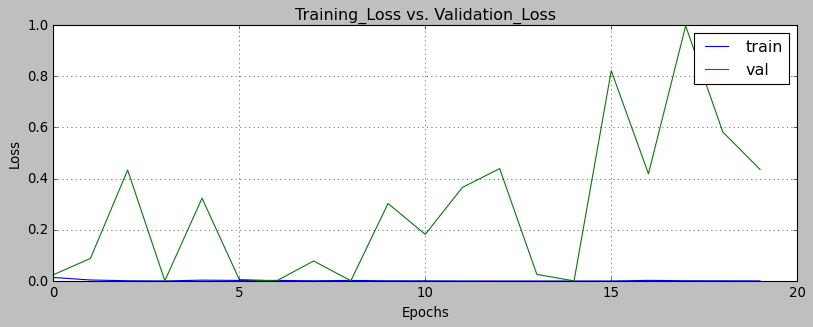

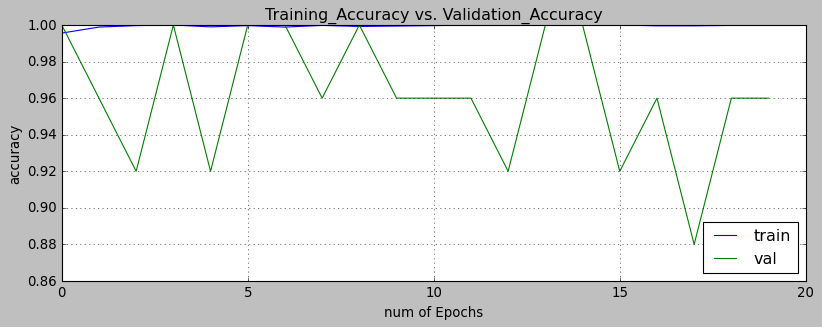

In [299]:
 epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(12,4))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training_Loss vs. Validation_Loss')
plt.grid(True)
plt.legend(['train','val'],loc='upper right')
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])


plt.figure(2,figsize=(12,4))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('Training_Accuracy vs. Validation_Accuracy')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

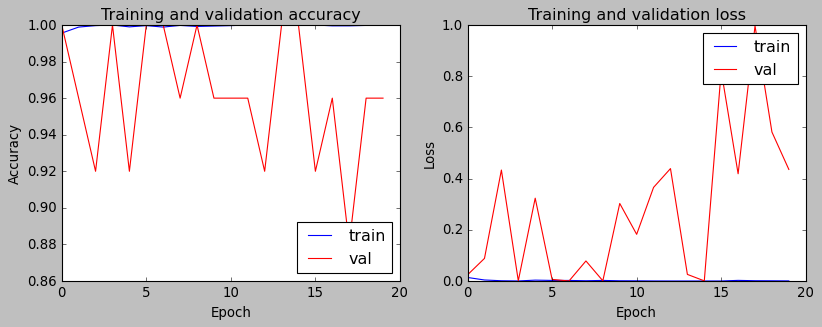

In [300]:
train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = 15
plt.figure(figsize=(12,4))

# Plotting the accuracy
plt.subplot(1,2,1)
plt.plot(xc,train_acc,'b')
plt.plot(xc,val_acc,'r')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')

# Plotting the loss
plt.subplot(1,2,2)
plt.plot(xc,train_loss,'b')
plt.plot(xc,val_loss,'r')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [301]:
 dir_dict = {'train': real, 'val': fake, 'test': fake}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.jpg"))))
        if len(label_list) == 0:
          continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count


In [305]:
test =data_with_aug.flow_from_directory("./raw/",
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (224, 224),
                                              shuffle=False)

test_scores = model.evaluate(test, steps=12611)
print("Test results Accuracy: {0:.2f}% and Loss: {0:.2f}".format(test_scores[1]*100, test_scores[0]))


threshold = 0.5  
y_pred_value = np.squeeze(model.predict(test, steps=12611, verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  
y_pred[y_pred_value > threshold] = 1

y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test.classes

# Sanity check on the y_pred and y_true value
print(f"Label\t\t: {y_true[:10]}")
print(f"Prediction\t: {y_pred[:10]}")

Found 12611 images belonging to 2 classes.
12611/12611 [==============================] - 497s 39ms/step - loss: 0.1013 - accuracy: 0.9906
Test results Accuracy: 99.06% and Loss: 99.06
12611/12611 [==============================] - 513s 41ms/step
Label		: [0 0 0 0 0 0 0 0 0 0]
Prediction	: [0 0 0 0 0 0 0 0 0 0]


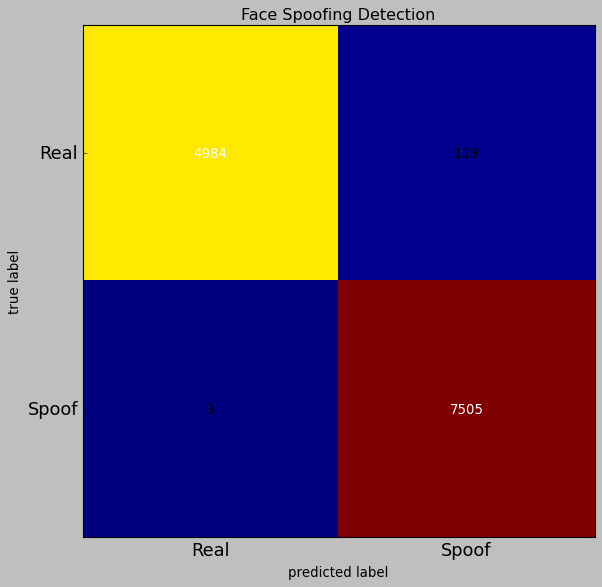

Report Summary:
Precision	: 98.44%
Recall		: 99.96%
F1 Score	: 99.19%

Notes: 
True labels	: Spoof
False labels	: Real


In [306]:
# Confusion matrix result
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()

# Precision and Recall metrics
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Report Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")